In [1]:
!pip install -q yfinance

!pip install mxnet

!pip install bayesian-optimization

!pip install xgboost


[*********************100%%**********************]  1 of 1 completed


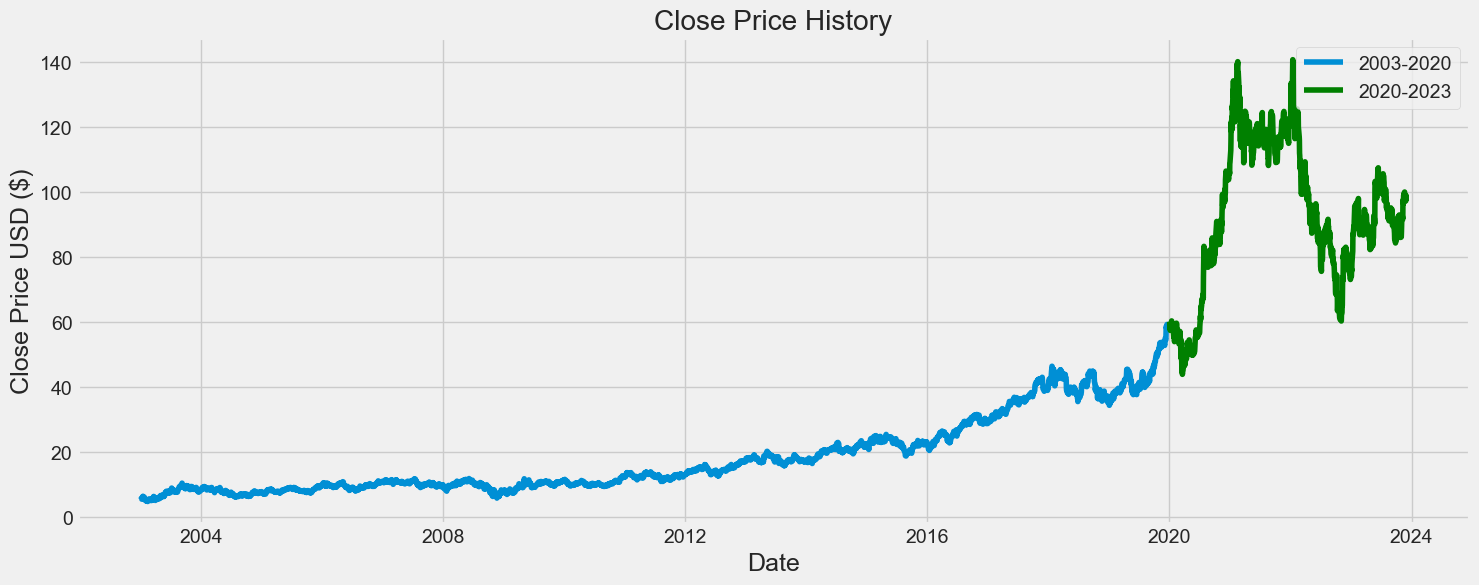

                Open      High       Low     Close  Adj Close   Volume
Date                                                                  
2003-01-02  5.342996  5.470032  5.260796  5.440141   2.775635  6774506
2003-01-03  5.447614  5.612014  5.447614  5.567178   2.840450  5766574
2003-01-06  5.589596  5.791359  5.559705  5.716632   2.916705  7918400
2003-01-07  5.776414  5.836196  5.679268  5.739050   2.928142  7438789
2003-01-08  5.679268  5.686741  5.477505  5.492450   2.802324  5619907


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
from datetime import datetime
import plotly.graph_objects as go

yf.pdr_override()

# Get the stock quote
df = pdr.get_data_yahoo('TSM', start='2003-01-01', end='2023-12-01')
# Load data from CSV file
# df = pd.read_csv('TSM_dataset.csv')

df_before_2020 = df[:'2019-12-31']
df_from_2020 = df['2020-01-01':]

plt.figure(figsize=(16,6))
plt.title('Close Price History')

plt.plot(df_before_2020['Close'], label='2003-2020')

plt.plot(df_from_2020['Close'], color='green', label='2020-2023')

plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend()
plt.show()
print(df.head())

def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Adj Close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Adj Close'].rolling(window=21).mean()
    dataset['ma42'] = dataset['Adj Close'].rolling(window=42).mean()

    # Create MACD
    dataset['26ema'] = dataset['Adj Close'].ewm(span=26, adjust=False).mean()
    dataset['12ema'] = dataset['Adj Close'].ewm(span=12, adjust=False).mean()
    dataset['MACD'] = dataset['12ema'] - dataset['26ema']


    # Create Bollinger Bands
    dataset['20sd'] = dataset['Adj Close'].rolling(window=20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)

    # Create Exponential moving average
    dataset['ema'] = dataset['Adj Close'].ewm(com=0.5).mean()

    # Create Momentum
    dataset['momentum'] = dataset['Adj Close']-1

    return dataset

def plot_data(df, width=800, height=400):
    dataset_table = df
    dataset_table = dataset_table.reset_index()

    columns_to_round = dataset_table.columns[1:]

    for col in columns_to_round:
        dataset_table[col] = dataset_table[col].astype(float).round(2)
    if 'Date' in dataset_table.columns:
        dataset_table['Date'] = dataset_table['Date'].dt.strftime('%Y-%m-%d')

    # Create a table
    fig = go.Figure(data=[go.Table(
        header=dict(values=list(dataset_table.columns),
                    fill_color='paleturquoise',
                    align='left'),
        cells=dict(values=[dataset_table[col][:5] for col in dataset_table.columns],
                fill_color='lavender',
                align='left',
                height=40,
                font=dict(size=12)))
    ])

    fig.update_layout(width = width, height = height)

    # Show the table
    fig.show()
plot_data(df)


[*********************100%%**********************]  1 of 1 completed


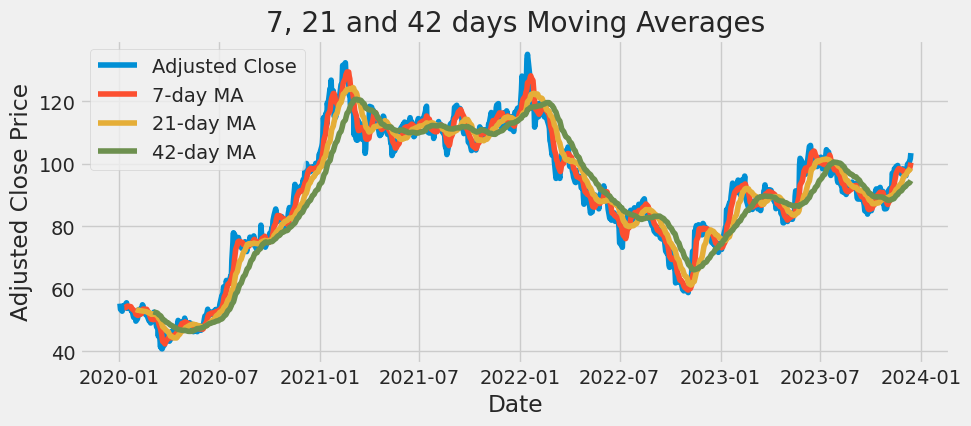

In [ ]:
df = pdr.get_data_yahoo('TSM', start='2020-01-01', end=datetime.now())
dataset = get_technical_indicators(df)
plt.figure(figsize=(10,4))
plt.plot(dataset['Adj Close'], label='Adjusted Close')
plt.plot(dataset['ma7'], label='7-day MA')
plt.plot(dataset['ma21'], label='21-day MA')
plt.plot(dataset['ma42'], label='42-day MA')
plt.title('7, 21 and 42 days Moving Averages')
plt.ylabel('Adjusted Close Price')
plt.xlabel('Date')
plt.legend()
plt.show()

[*********************100%%**********************]  1 of 1 completed


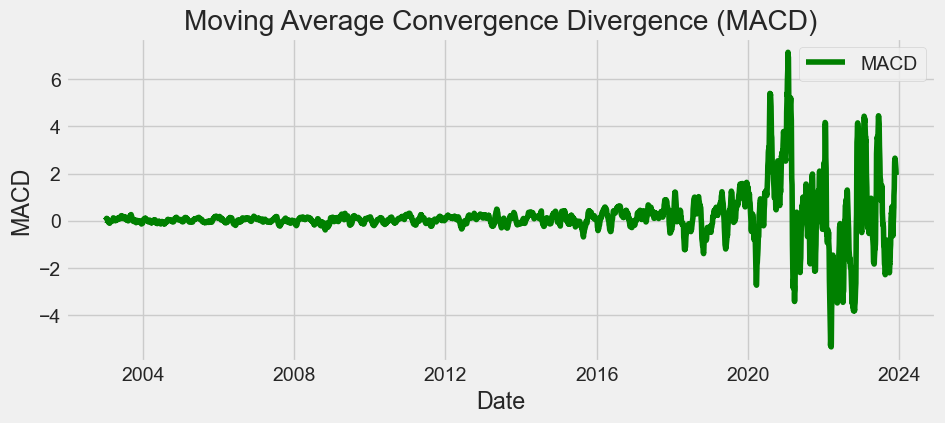

In [ ]:
df = pdr.get_data_yahoo('TSM', start='2003-01-01', end=datetime.now())
dataset = get_technical_indicators(df)

plt.figure(figsize=(10,4))
plt.plot(dataset['MACD'], label='MACD', color = 'green')
plt.title('Moving Average Convergence Divergence (MACD)')
plt.ylabel('MACD')
plt.xlabel('Date')
plt.legend()
plt.show()

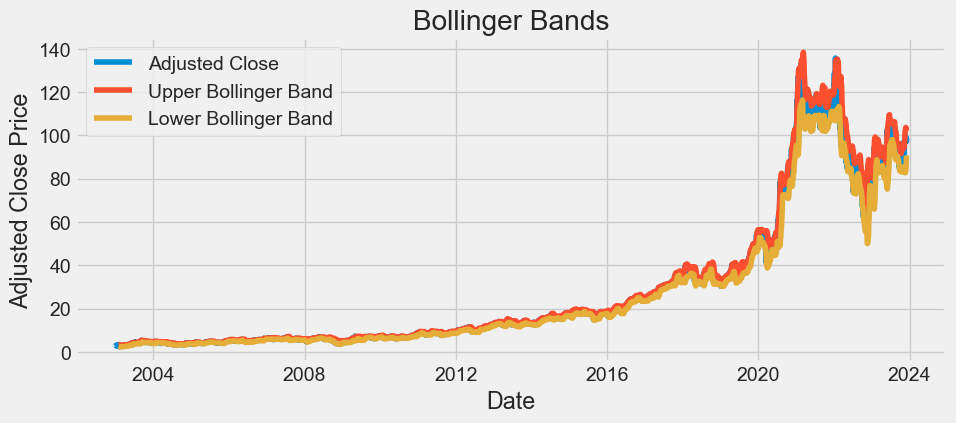

In [ ]:

plt.figure(figsize=(10,4))
plt.plot(dataset['Adj Close'], label='Adjusted Close')
plt.plot(dataset['upper_band'], label='Upper Bollinger Band')
plt.plot(dataset['lower_band'], label='Lower Bollinger Band')
plt.fill_between(dataset.index, dataset['upper_band'], dataset['lower_band'], color='gray', alpha=0.3)
plt.title('Bollinger Bands')
plt.ylabel('Adjusted Close Price')
plt.xlabel('Date')
plt.legend()
plt.show()

In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, TimeDistributed, Dropout, Bidirectional, Reshape, Input, BatchNormalization, GRU
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping, Callback
from keras.activations import gelu
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import TruncatedSVD, PCA
import keras.backend as K
import math
from bayes_opt import BayesianOptimization
from functools import partial
import xgboost as xgb
import time

# time steps
window_size = 60

def split_windows(data, size):
    X = []
    Y = []
    for i in range(len(data) - size):
        X.append(data[i:i+size, :])
        Y.append(data[i+size, 3])
    return np.array(X), np.array(Y)

def create_cnn_lstm_model(input_shape, dropout_rate, lstm_units_2, dense_units, pool_size, activation = 'relu', use_gru = False, **kwargs):
    # Get the activation function
    if activation == 'gelu':
        activation_function = gelu
    else:
        activation_function = 'relu'

    model = Sequential()

    # CNN layers
    model.add(Conv2D(filters=64, kernel_size=3, activation=activation_function, padding="same", strides=1, input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=int(pool_size), padding="same", strides=1))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(filters=64, kernel_size=3, activation=activation_function, padding="same", strides=1))
    model.add(MaxPooling2D(pool_size=int(pool_size), padding="same", strides=1))
    model.add(Dropout(dropout_rate))

    model.add(Reshape((window_size, -1)))

    # LSTM layers
    if use_gru:
        model.add(GRU(units=128, return_sequences=True))
        model.add(GRU(units=int(lstm_units_2), return_sequences=False))
    else:
        model.add(LSTM(units=128, return_sequences=True))
        model.add(LSTM(units=int(lstm_units_2), return_sequences=False))

    # Dense layers for output
    model.add(Dense(units=int(dense_units), activation=activation_function))
    model.add(Dense(units=1))

    return model

def train_evaluate_model(x_train, y_train, x_test, y_test, activation, use_gru, lstm_units_2, dense_units, dropout_rate, batch_size, learning_rate, epochs, pool_size, **kwargs):
    input_shape = (x_train.shape[1], x_train.shape[2], 1)

    model = create_cnn_lstm_model(input_shape, dropout_rate, lstm_units_2, dense_units, pool_size, activation, use_gru)

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    model.fit(x_train, y_train, batch_size=int(batch_size), epochs=int(epochs), verbose=0)

    predictions = model.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    return -rmse # Minimize the RMSE

# apply bayesian optimization to find the best model parameters
def find_best_model_parameters(pbounds, x_train, y_train, x_test, y_test, activation = 'relu', use_gru = False):
    # Set the parameters that won't be optimized
    optimized_function = partial(
        train_evaluate_model,
        pbounds=pbounds,
        x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, activation=activation, use_gru=use_gru
    )

    optimizer = BayesianOptimization(
        f=optimized_function,
        pbounds=pbounds,
        random_state=1,
        verbose=0
    )

    optimizer.maximize(init_points=2, n_iter=10)

    print("Best Parameters:", optimizer.max)
    return optimizer.max

def train_model(model, x_train, y_train, batch_size = 1, learning_rate = 0.01, epochs=3, **kwargs):
    # Create the Learning Rate Scheduler
    min_lr = 0.001
    max_lr = 0.006
    cycle_length = 1000
    scheduler = create_clr_scheduler(min_lr, max_lr, cycle_length)

    # Splitting the training data into train and validation sets (90% train, 10% validation)
    x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

    # Setting up early stopping parameters
    early_stopping = EarlyStopping(
        monitor='val_loss',  # The metric to monitor
        min_delta=0.001,     # Minimum change to qualify as an improvement
        patience=3,         # How many epochs to wait before stopping
        verbose=1,           # Logging mode
        mode='min',          # The mode: 'min' implies we are minimizing the monitored quantity
        restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
    )

    # Compile the model
    model.compile(Adam(clipvalue=0.5, learning_rate=learning_rate), loss='mean_squared_error')

    # model.compile(loss='mean_squared_error',
    #           optimizer=SGD(learning_rate=0.1),
    #           metrics=['mse'])

    start_time = time.time()
    # Train the model
    history = model.fit(x_train_split, y_train_split, validation_data=(x_val_split, y_val_split), batch_size=round(batch_size), epochs=round(epochs), callbacks=[scheduler, early_stopping], verbose=1)
    # model.fit(x_train, y_train, batch_size=round(batch_size), epochs=round(epochs), callbacks=[callable], verbose=1)
    end_time = time.time()
    total_training_time = end_time - start_time
    print(f"Total training time: {total_training_time:.2f} seconds")

    # Plotting training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# evaluate the accuracy of the model
def evaluate_model(predictions, y_test):
    # Get the root mean squared error (RMSE)
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    print(f'RMSE {rmse}')
    accuracy = calculate_accuracy(predictions, y_test)
    print(f'Accuracy {accuracy}')

def calculate_accuracy(predictions, y_test):
    tolerance = 5
    correct_predictions = np.abs(y_test - predictions) <= tolerance
    accuracy = np.mean(correct_predictions)
    return accuracy

def preprocess_dataset(dataset):
    # Fill missing values in the dataset.
    dataset.ffill(inplace=True)

    # fill these NaN values from the next valid observation.
    dataset.bfill(inplace=True)

    # fill with a constant value like 0.0. Adjust this strategy as needed.
    dataset.fillna(0.0, inplace=True)

    return dataset

def apply_fourier_transform(dataset, columns=['Open', 'High', 'Low', 'Close', 'Adj Close'], components=[3, 6], overwrite=False, plot=False, plot_start='2018-01-01', plot_end='2023-01-01'):
    """
    Apply Fourier Transform to specified columns of the dataset. Depending on the 'overwrite' parameter, either append the transformed data to the original dataset or overwrite the original columns.

    Parameters:
    dataset (DataFrame): The dataset containing stock price information.
    columns (list): List of column names to which Fourier Transform will be applied.
    components (list): List of component numbers to use for Fourier Transform.
    overwrite (bool): If True, overwrite the original columns with the transformed data.

    Returns:
    DataFrame: Modified dataset with Fourier transformed features.
    """
    for column in columns:
        if plot:
            plt.figure(figsize=(16,6))
            plt.plot(dataset.loc[plot_start:plot_end, column], label='Original', linewidth=2.0)

        fft_values = np.fft.fft(np.asarray(dataset[column].tolist()))
        original_values = dataset[column].values

        for comp in components:
            # Apply Fourier Transform with specified number of components
            fft_values_m = np.copy(fft_values)
            fft_values_m[comp:-comp] = 0  # Zero out components outside the specified range
            transformed_column = np.fft.ifft(fft_values_m)

            # Cap the transformed values if they deviate from the original by more than 10
            capped_transformed = transformed_column.real
            deviation = transformed_column.real - original_values
            capped_transformed = np.where(np.abs(deviation) > 20, original_values + np.sign(deviation) * 20, transformed_column.real)

            # Append or overwrite the transformed data
            column_name = f'fft_{column}_{comp}'
            if overwrite:
                dataset[column] = capped_transformed
            else:
                dataset[column_name] = capped_transformed

            if plot:
                plt.plot(dataset.loc[plot_start:plot_end, column_name], label=f'Transformed {column} (Comp {comp})', linewidth=2.0)

    if plot:
        plt.title('Original vs Transformed Data')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

    return dataset

def add_arima_predictions_to_dataset(data, target_column='Close', train_ratio=0.66, arima_order=(5,1,0)):
    # Prepare the dataset for ARIMA model
    X = data[target_column].values
    size = int(len(X) * train_ratio)
    train, test = X[0:size], X[size:len(X)]

    # ARIMA model predictions
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(method_kwargs={"disp": 0})
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        history.append(test[t])

    # Calculate mean squared error if needed
    # error = mean_squared_error(test, predictions)
    # print('Test MSE: %.3f' % error)

    # Add predictions to the dataset
    arima_predictions = [np.nan] * len(train) + predictions
    data[f'ARIMA_{target_column}_Predictions'] = arima_predictions

    return data

def train_and_apply_autoencoder(data, columns_to_compress, encoding_dim=3, epochs=50, batch_size=256, overwrite_original=False):
    # Select columns to compress
    data_to_compress = data[columns_to_compress]

    # Scale the selected data
    scaler = MinMaxScaler(feature_range=(0,1))
    data_scaled = scaler.fit_transform(data_to_compress)
    input_dim = data_scaled.shape[1]

    # Build and train the autoencoder
    input_layer = Input(shape=(input_dim,))
    # Encoder
    encoded = Dense(128, activation='elu')(input_layer)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.5)(encoded)
    encoded = Dense(64, activation='elu')(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.5)(encoded)
    encoded = Dense(encoding_dim, activation='elu')(encoded)

    # Decoder
    decoded = Dense(64, activation='elu')(encoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(0.5)(decoded)
    decoded = Dense(128, activation='elu')(decoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(0.5)(decoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)

    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)
    autoencoder.compile(optimizer=RMSprop(learning_rate=0.001), loss='mean_squared_error')
    autoencoder.fit(data_scaled, data_scaled, epochs=epochs, batch_size=batch_size, shuffle=True, validation_split=0.2, verbose=0)

    # Generate new features
    new_features = encoder.predict(data_scaled)

    # Train a new scaler for the new features
    new_feature_scaler = MinMaxScaler(feature_range=(0, 1))
    new_features_scaled = new_feature_scaler.fit_transform(new_features)

    # Inverse transform the new features to the original scale
    new_features_original_scale = new_feature_scaler.inverse_transform(new_features_scaled)

    # Overwrite or append new features to the dataset
    if overwrite_original:
        # Drop original columns to be compressed
        data = data.drop(columns=columns_to_compress)

        # Add new features
        for i in range(encoding_dim):
            data[f'compressed_feature_{i}'] = new_features_original_scale[:, i]
    else:
        # Append new features to the dataset
        new_feature_df = pd.DataFrame(new_features_original_scale, columns=[f'compressed_feature_{i}' for i in range(encoding_dim)])
        data = pd.concat([data.reset_index(drop=True), new_feature_df], axis=1)

    return data

def apply_svd_or_pca(data, columns_to_compress, n_components=3, overwrite_original=False, type = 'svd'):
    # Extract the data to compress
    data_to_compress = data[columns_to_compress]

    scaler = StandardScaler()
    data_to_compress = scaler.fit_transform(data_to_compress)

    if type == 'svd':
        # Apply SVD
        svd = TruncatedSVD(n_components=n_components, random_state=42)
        compressed_features = svd.fit_transform(data_to_compress)
    elif type == 'pca':
        # Apply PCA
        pca = PCA(n_components=n_components)
        compressed_features = pca.fit_transform(data_to_compress)

    # Overwrite or append new features to the dataset
    if overwrite_original:
        # Drop original columns to be compressed
        data = data.drop(columns=columns_to_compress)

        # Add new features
        for i in range(n_components):
            data[f'compressed_feature_{i}'] = compressed_features[:, i]
    else:
        # Append new features to the dataset
        svd_feature_df = pd.DataFrame(compressed_features, columns=[f'compressed_feature_{i}' for i in range(n_components)])
        data = pd.concat([data.reset_index(drop=True), svd_feature_df], axis=1)

    return data

class TriangularSchedule:
    def __init__(self, min_lr, max_lr, cycle_length, inc_fraction=0.5):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.cycle_length = cycle_length
        self.inc_fraction = inc_fraction

    def __call__(self, iteration):
        if iteration <= self.cycle_length * self.inc_fraction:
            unit_cycle = iteration / (self.cycle_length * self.inc_fraction)
        elif iteration <= self.cycle_length:
            unit_cycle = (self.cycle_length - iteration) / (self.cycle_length * (1 - self.inc_fraction))
        else:
            unit_cycle = 0
        return (unit_cycle * (self.max_lr - self.min_lr)) + self.min_lr

class CyclicalSchedule:
    def __init__(self, schedule_class, cycle_length, cycle_length_decay=1, cycle_magnitude_decay=1, **kwargs):
        self.schedule_class = schedule_class
        self.length = cycle_length
        self.length_decay = cycle_length_decay
        self.magnitude_decay = cycle_magnitude_decay
        self.kwargs = kwargs

    def __call__(self, iteration):
        cycle_idx = 0
        cycle_length = self.length
        idx = cycle_length
        while idx <= iteration:
            cycle_length = math.ceil(cycle_length * self.length_decay)
            cycle_idx += 1
            idx += cycle_length
        cycle_offset = iteration - idx + cycle_length

        # Creating an instance of the schedule_class with updated cycle_length for the current cycle.
        schedule = self.schedule_class(cycle_length=cycle_length, **self.kwargs)
        # Calculate the learning rate for the current iteration within the current cycle.
        return schedule(cycle_offset) * (self.magnitude_decay ** cycle_idx)

class CyclicalLearningRateScheduler(Callback):
    def __init__(self, schedule):
        super(CyclicalLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Calculate scheduled learning rate
        scheduled_lr = self.schedule(epoch)
        # Set the learning rate in the optimizer
        K.set_value(self.model.optimizer.lr, scheduled_lr)
        print(f'Epoch {epoch+1}: Cyclical Learning Rate is {scheduled_lr:.6f}.')

def create_clr_scheduler(min_lr, max_lr, cycle_length):
    cyclical_schedule = CyclicalSchedule(TriangularSchedule, cycle_length, cycle_length_decay=1, cycle_magnitude_decay=0.5, min_lr=min_lr, max_lr=max_lr)
    clr_scheduler = CyclicalLearningRateScheduler(cyclical_schedule)
    return clr_scheduler

def evaluate_feature_importance(data, target_column='Close', test_size=0.05):
    # Prepare the data
    X = data.drop(target_column, axis=1)
    y = data[target_column]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Create and train the model
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
    xgb_model.fit(X_train, y_train, verbose=False)

    # Predict and calculate RMSE
    y_pred = xgb_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    # print(f"Root Mean Squared Error: {rmse}")

    # Get feature importance
    feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': xgb_model.feature_importances_}).sort_values(by='Importance', ascending=False)

    # Optionally, you can plot the feature importance for better visualization
    feature_importance.plot(kind='bar', x='Feature', y='Importance', title='Feature Importance')
    plt.show()

    return feature_importance

def get_low_importance_features(feature_importance_df, threshold=0.01):
    
    low_importance_features = feature_importance_df[feature_importance_df['Importance'] < threshold]['Feature'].tolist()

    return low_importance_features

In [10]:
def start_to_train_stock_model(call_arima=True, dimensionality_reduction='autoencoder', call_bayesian_opt=True, activation='relu', use_gru=False):
    # Get the dataset
    df = pdr.get_data_yahoo('TSM', start='2003-01-01', end='2023-12-01')

    # Get the technical indicators from the original datasets
    data = get_technical_indicators(df)
    # data = data.filter(['Open', 'High', 'Low', 'Close', 'Volume', 'lower_band'])

    # Apply Fourier Transform to the dataset
    data = apply_fourier_transform(data, components=[50], columns=['Close'], overwrite=False)

    # Add ARIMA predictions to the dataset
    if call_arima:
        add_arima_predictions_to_dataset(data, target_column='Close', train_ratio=0.66, arima_order=(5,1,0))

    # Check if there are any NaN values in the dataset
    data = preprocess_dataset(data)

    # Get feature importance scores using XGBoost
    feature_importance = evaluate_feature_importance(data)
    low_importance_features = get_low_importance_features(feature_importance, threshold=0.01)

    # all_columns = data.columns.tolist()
    # columns_not_to_compress = ['Open', 'High', 'Low', 'Close', 'Adj Close']
    # Obtain the list of columns to compress by excluding the specified columns
    # columns_to_compress = [col for col in all_columns if col not in columns_not_to_compress]
    # Train the autoencoder and Generate enhanced dataset
    if dimensionality_reduction == 'autoencoder':
        data = train_and_apply_autoencoder(data, columns_to_compress=low_importance_features, encoding_dim=3, epochs=50, batch_size=256, overwrite_original=True)
    elif dimensionality_reduction == 'svd' or dimensionality_reduction == 'pca':
        data = apply_svd_or_pca(data, columns_to_compress=low_importance_features, n_components=3, overwrite_original=True, type=dimensionality_reduction)

    # Convert the dataframe to a numpy array
    dataset = data.values
    # Get the number of rows to train the model on
    training_data_len = int(np.ceil( len(dataset) * .95 ))

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)

    scaler_target = MinMaxScaler(feature_range=(0,1))
    scaler_target.fit_transform(dataset[:, 3].reshape(-1, 1))
    # Create the training data set
    train_data = scaled_data[0:int(training_data_len), :]

    # Create the testing data set
    test_data = scaled_data[training_data_len - 60: , :]

    # Split the data into x_train and y_train data sets
    x_train, y_train = split_windows(train_data, window_size)
    # Split the data into x_test and y_test data sets
    x_test, y_test = split_windows(test_data, window_size)

    # Reshape the data
    # x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) # (samples, time steps, features)

    # apply bayesian optimization to find the best model parameters
    if call_bayesian_opt:
        pbounds = {
            'lstm_units_2': (32, 128),
            'dense_units': (16, 64),
            'dropout_rate': (0.2, 0.7),
            'batch_size': (1, 1),
            'learning_rate': (0.001, 0.01),
            'epochs': (1, 7),
            'pool_size': (1, 5),
        }
        best_params = find_best_model_parameters(pbounds, x_train, y_train, x_test, y_test, activation=activation, use_gru=use_gru)['params']
    else:
        # example of best parameters
        best_params = {
            'batch_size': 1,
            'dense_units': 62.99350004640118,
            'dropout_rate': 0.23142184670902094,
            'epochs': 5,
            'learning_rate': 0.009332022336633609,
            'lstm_units_2': 32.031291140015846,
            'pool_size': 2,
        }

    # Build the CNN-LSTM model
    input_shape = (x_train.shape[1], x_train.shape[2], 1)
    model = create_cnn_lstm_model(input_shape, activation=activation, use_gru=use_gru, **best_params)

    # Train the model with the Learning Rate Scheduler and Early Stopping
    train_model(model, x_train, y_train, **best_params)

    # Get the models predicted price values
    predictions = model.predict(x_test)
    predictions = scaler_target.inverse_transform(predictions)
    y_test = y_test.reshape(-1, 1)
    y_test = scaler_target.inverse_transform(y_test)
    # print(f'P {predictions}')
    # print(f'Y {y_test}')

    evaluate_model(predictions, y_test)

    # Plot the data
    train = data[:training_data_len]
    valid = data[training_data_len:].copy()
    valid['Predictions'] = predictions
    # Visualize the data
    plt.figure(figsize=(16,6))
    plt.title('Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()


[*********************100%%**********************]  1 of 1 completed


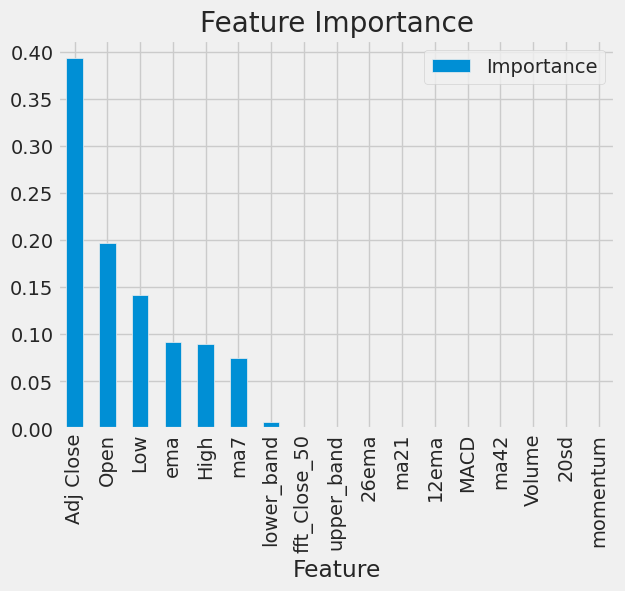

165/165 [==============================] - 0s 1ms/step
Epoch 1: Cyclical Learning Rate is 0.001000.
Epoch 1/5
4447/4447 [==============================] - 47s 10ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 2: Cyclical Learning Rate is 0.001010.
Epoch 2/5
4447/4447 [==============================] - 42s 9ms/step - loss: 8.3581e-04 - val_loss: 5.9793e-04
Epoch 3: Cyclical Learning Rate is 0.001020.
Epoch 3/5
4447/4447 [==============================] - 43s 10ms/step - loss: 7.1021e-04 - val_loss: 5.5193e-04
Epoch 4: Cyclical Learning Rate is 0.001030.
Epoch 4/5
4447/4447 [==============================] - 41s 9ms/step - loss: 5.2907e-04 - val_loss: 4.8213e-04
Epoch 5: Cyclical Learning Rate is 0.001040.
Epoch 5/5
4447/4447 [==============================] - 41s 9ms/step - loss: 4.5217e-04 - val_loss: 3.3105e-04
Epoch 5: early stopping
Total training time: 213.64 seconds


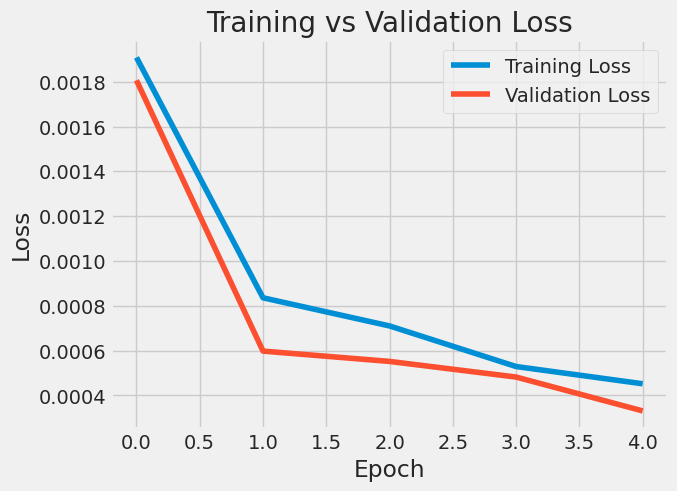

9/9 [==============================] - 1s 6ms/step
RMSE 4.51458018070992
Accuracy 0.7756653992395437


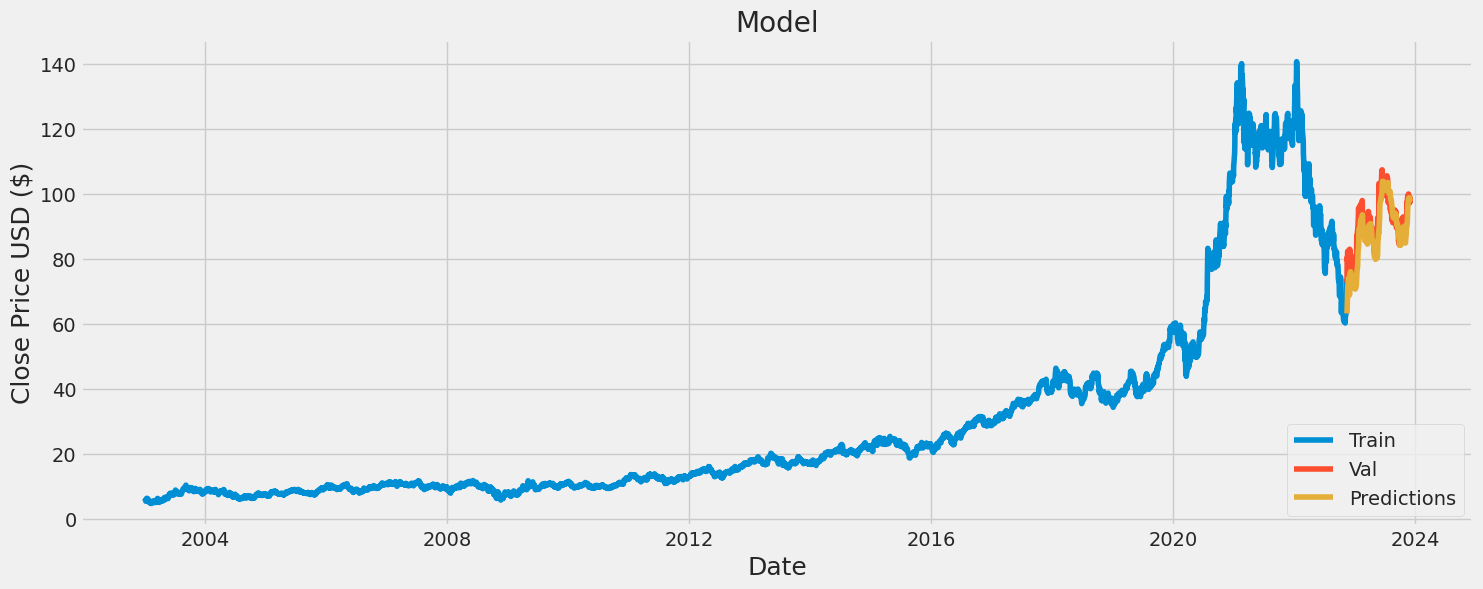

In [ ]:
start_to_train_stock_model(call_arima=True, dimensionality_reduction='autoencoder', call_bayesian_opt=True, activation='relu', use_gru=False)

[*********************100%%**********************]  1 of 1 completed


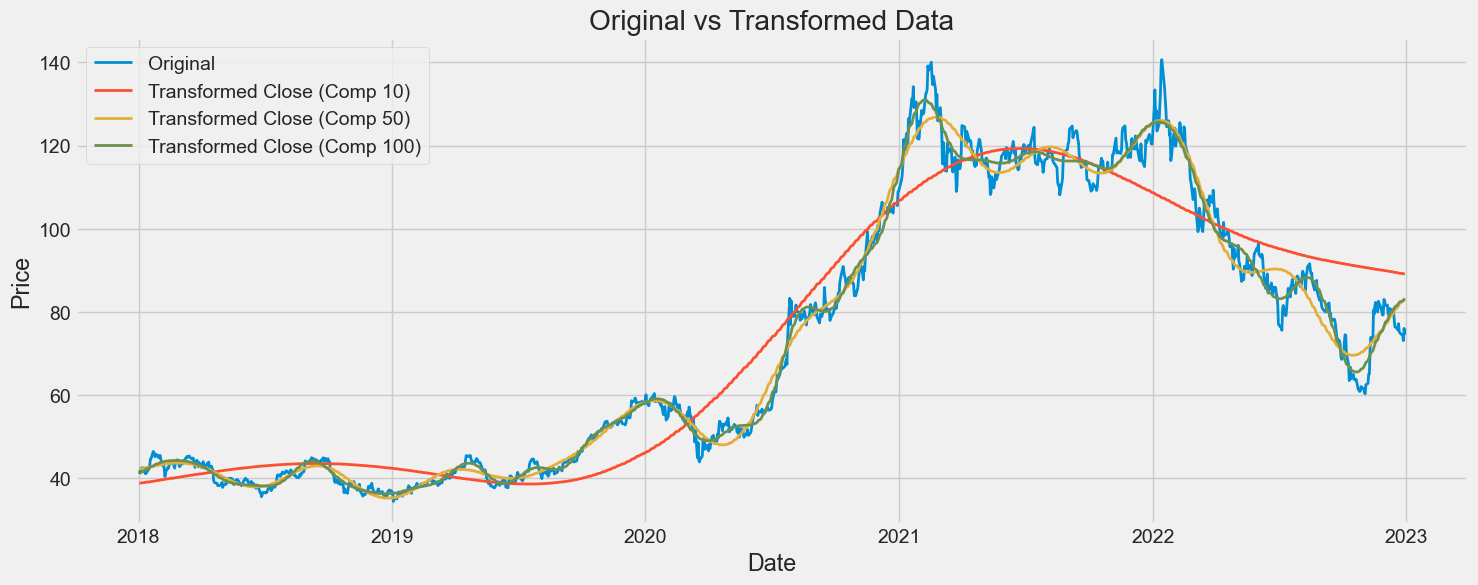

In [ ]:
df = pdr.get_data_yahoo('TSM', start='2003-01-01', end=datetime.now())

# Get the technical indicators from the original datasets
data = get_technical_indicators(df)
# data = data.filter(['Open', 'High', 'Low', 'Close', 'Volume', 'lower_band'])

# Apply Fourier Transform to the dataset
data = apply_fourier_transform(data, components=[10, 50, 100], columns=['Close'], overwrite=False, plot=True)

[*********************100%%**********************]  1 of 1 completed
Root Mean Squared Error: 0.5231405639046297


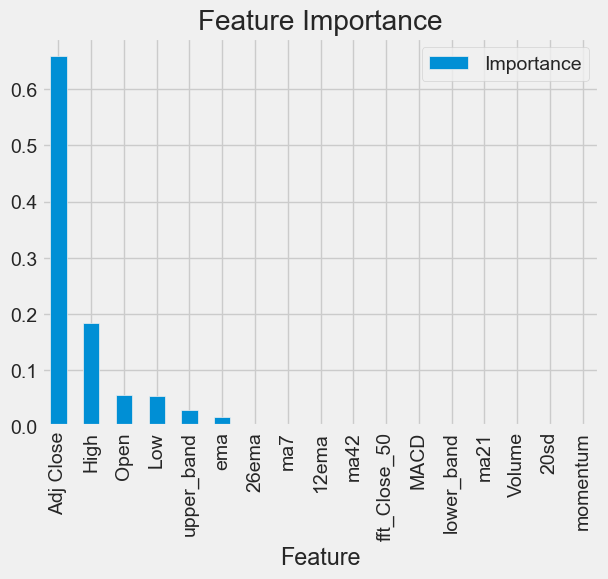

165/165 [==============================] - 0s 1ms/step
Epoch 1: Cyclical Learning Rate is 0.001000.
Epoch 1/2
4447/4447 [==============================] - 280s 62ms/step - loss: 0.0029 - val_loss: 5.4985e-04
Epoch 2: Cyclical Learning Rate is 0.001010.
Epoch 2/2
4447/4447 [==============================] - 235s 53ms/step - loss: 0.0010 - val_loss: 8.1162e-04
Epoch 2: early stopping


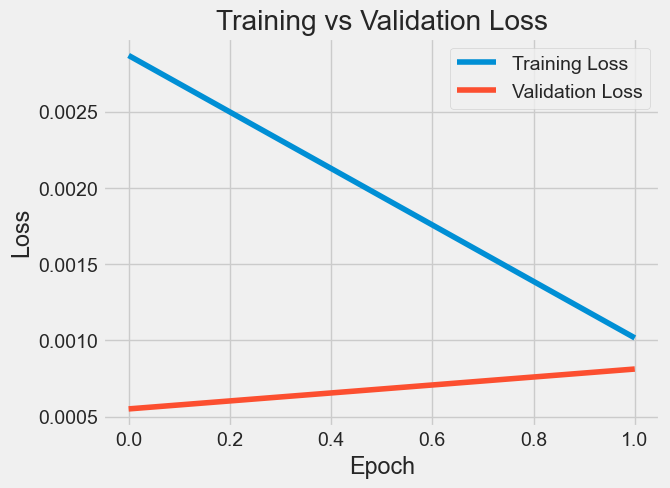

9/9 [==============================] - 2s 90ms/step
RMSE 3.9270944026950323
Accuracy 0.7832699619771863


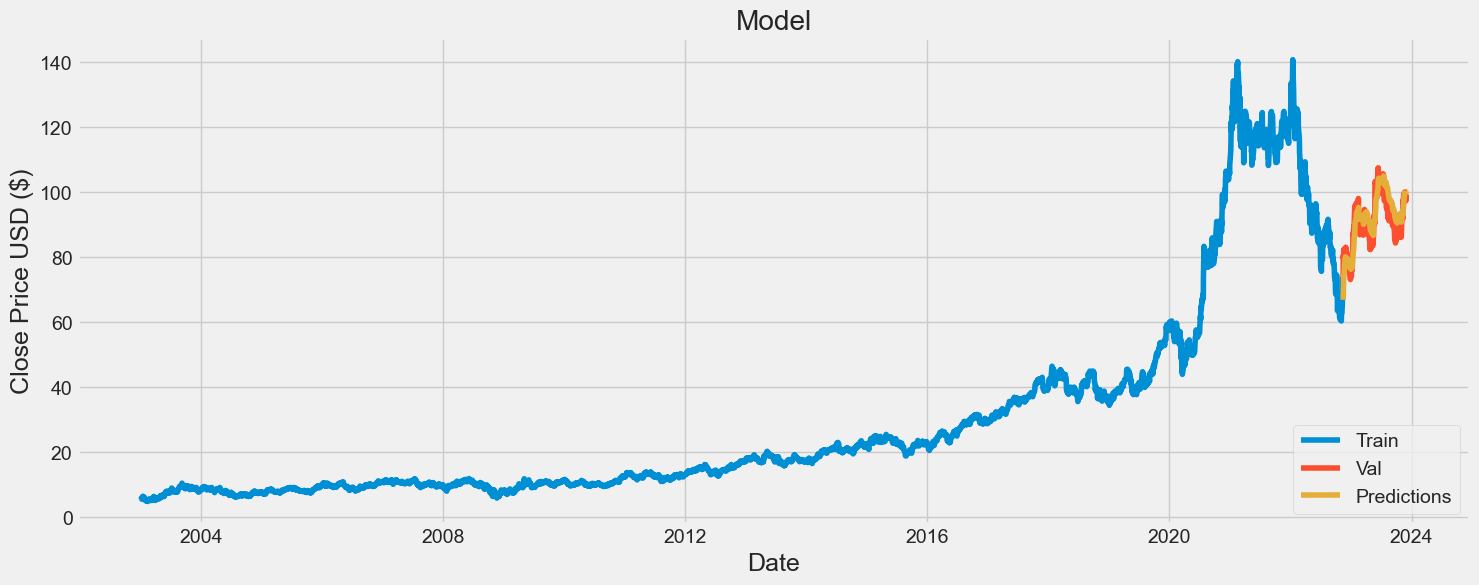

In [ ]:
start_to_train_stock_model(call_arima=True, dimensionality_reduction='autoencoder', call_bayesian_opt=True, activation='relu', use_gru=True)

[*********************100%%**********************]  1 of 1 completed
Root Mean Squared Error: 0.48903727175029343


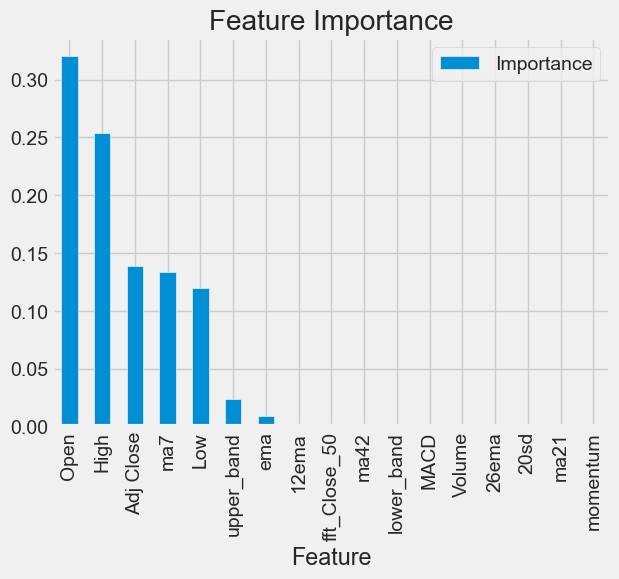

Epoch 1: Cyclical Learning Rate is 0.001000.
Epoch 1/2
4456/4456 [==============================] - 235s 52ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 2: Cyclical Learning Rate is 0.001010.
Epoch 2/2
4456/4456 [==============================] - 240s 54ms/step - loss: 9.1239e-04 - val_loss: 6.8878e-04
Epoch 2: early stopping


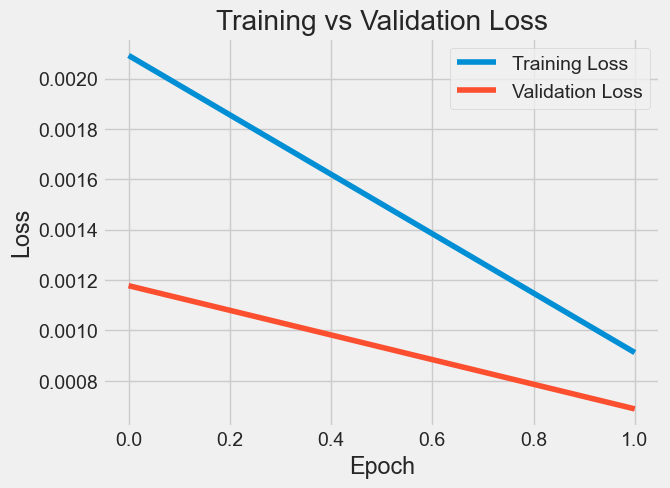

9/9 [==============================] - 1s 41ms/step
RMSE 5.111877351942901
Accuracy 0.6730038022813688


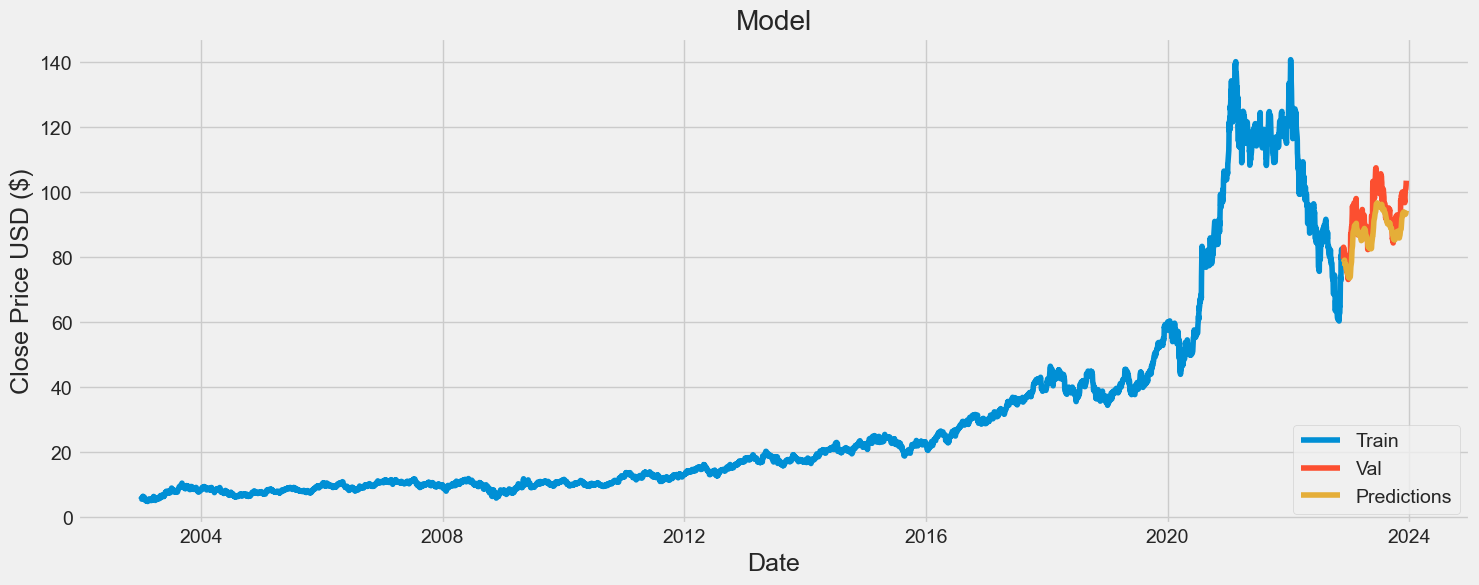

In [ ]:
start_to_train_stock_model(call_arima=True, dimensionality_reduction='svd', call_bayesian_opt=True, activation='relu', use_gru=False)

[*********************100%%**********************]  1 of 1 completed
Root Mean Squared Error: 0.48903855089199366


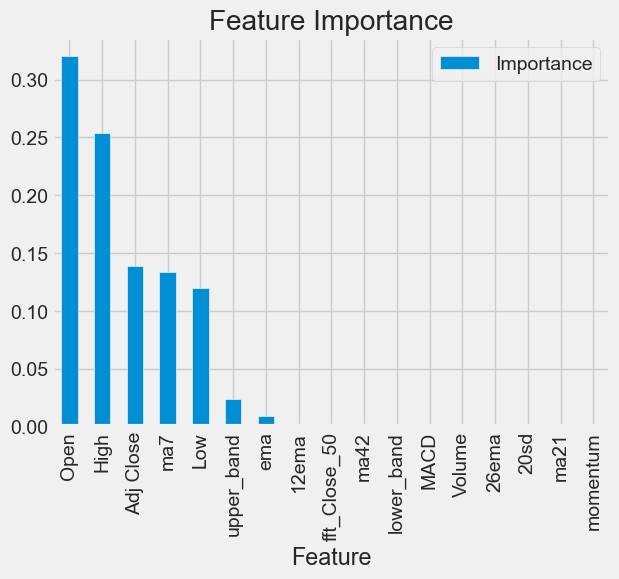

Epoch 1: Cyclical Learning Rate is 0.001000.
Epoch 1/2
4456/4456 [==============================] - 421s 94ms/step - loss: 0.0021 - val_loss: 7.0914e-04
Epoch 2: Cyclical Learning Rate is 0.001010.
Epoch 2/2
4456/4456 [==============================] - 397s 89ms/step - loss: 8.1136e-04 - val_loss: 1.7289e-04
Epoch 2: early stopping


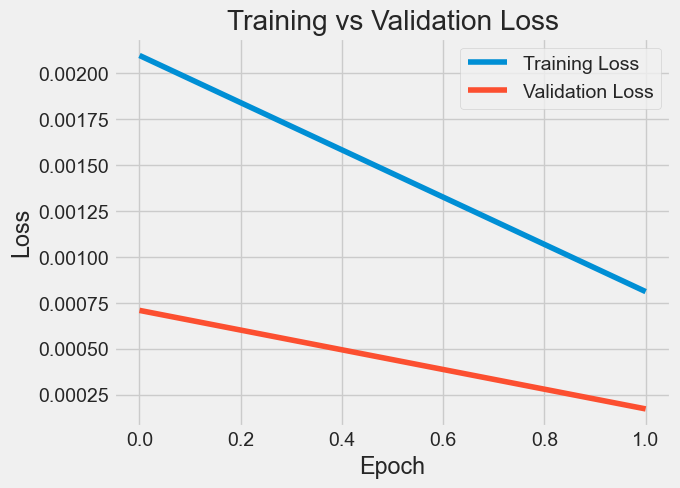

9/9 [==============================] - 2s 78ms/step
RMSE 3.3978952633684574
Accuracy 0.8935361216730038


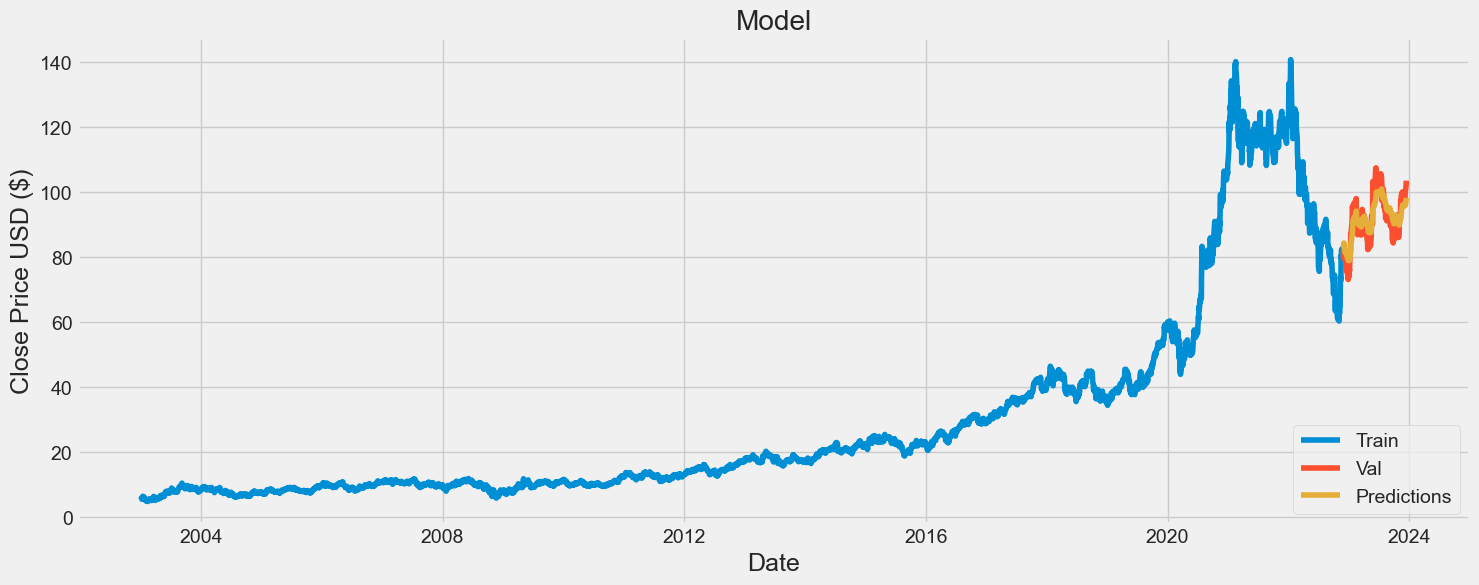

In [ ]:
start_to_train_stock_model(call_arima=True, dimensionality_reduction='none', call_bayesian_opt=True, activation='relu', use_gru=False)

[*********************100%%**********************]  1 of 1 completed


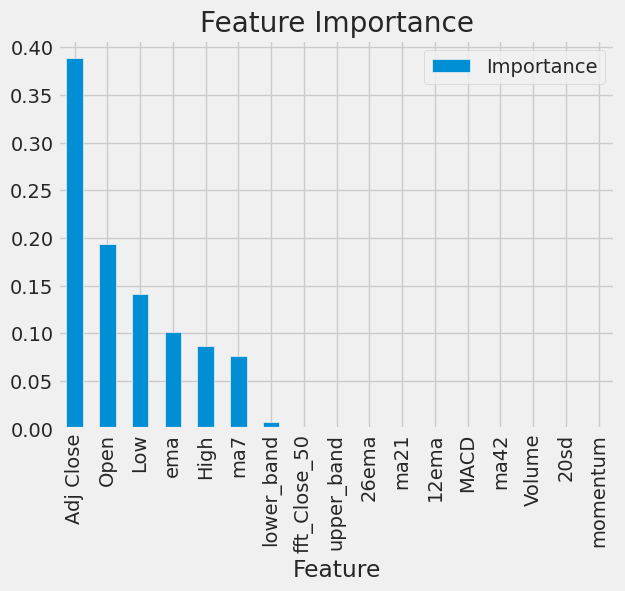

Epoch 1: Cyclical Learning Rate is 0.001000.
Epoch 1/5
4447/4447 [==============================] - 475s 106ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 2: Cyclical Learning Rate is 0.001010.
Epoch 2/5
4447/4447 [==============================] - 445s 100ms/step - loss: 8.1332e-04 - val_loss: 9.8043e-04
Epoch 3: Cyclical Learning Rate is 0.001020.
Epoch 3/5
4447/4447 [==============================] - 444s 100ms/step - loss: 6.8192e-04 - val_loss: 3.4896e-04
Epoch 4: Cyclical Learning Rate is 0.001030.
Epoch 4/5
4447/4447 [==============================] - 453s 102ms/step - loss: 4.5829e-04 - val_loss: 4.1481e-04
Epoch 5: Cyclical Learning Rate is 0.001040.
Epoch 5/5
4447/4447 [==============================] - 443s 100ms/step - loss: 4.6420e-04 - val_loss: 1.5104e-04
Total training time: 2305.98 seconds


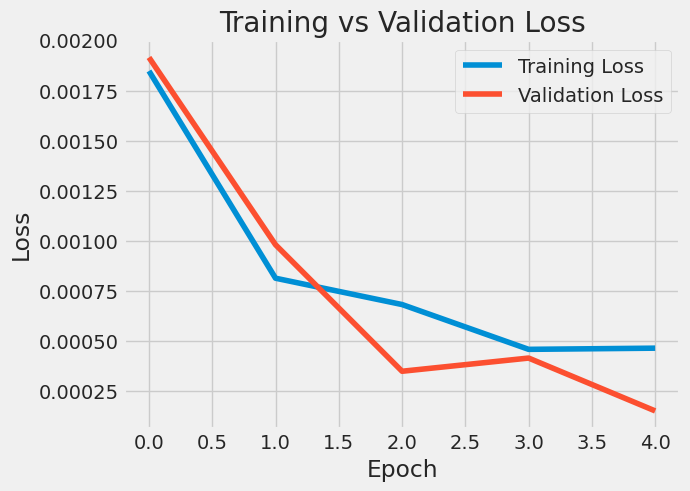

9/9 [==============================] - 2s 88ms/step
RMSE 5.053383456829831
Accuracy 0.6653992395437263


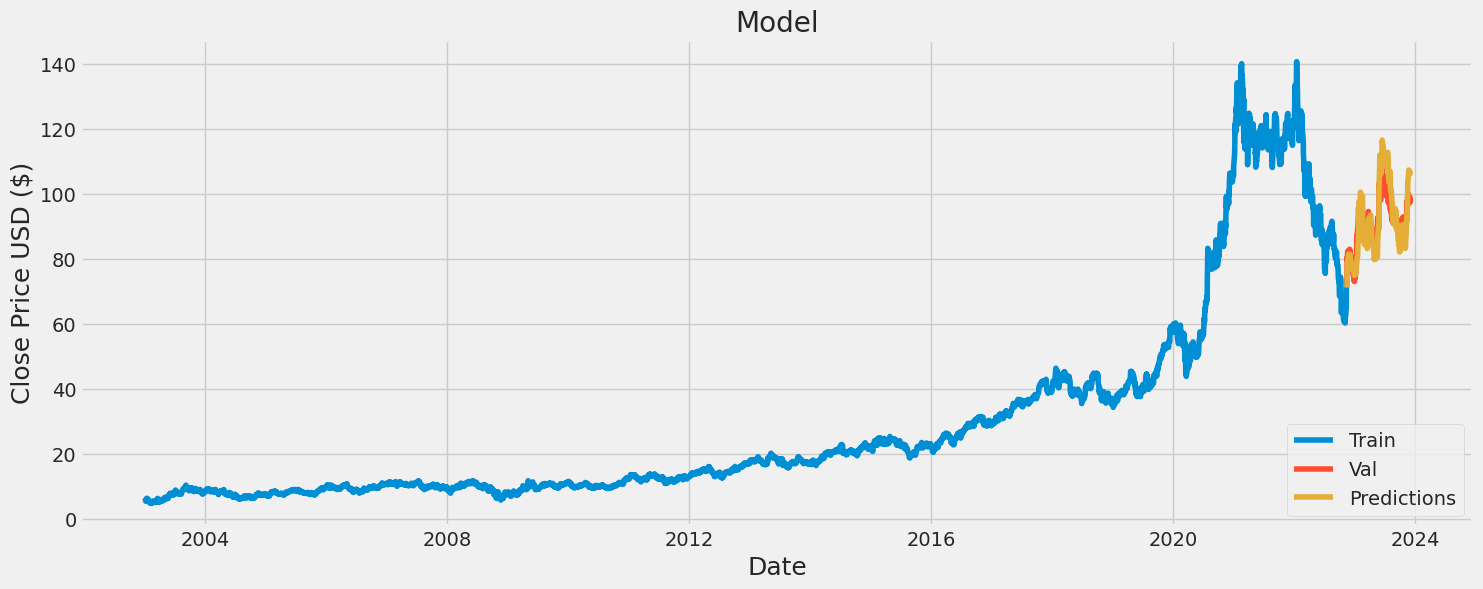

In [9]:
start_to_train_stock_model(call_arima=True, dimensionality_reduction='pca', call_bayesian_opt=True, activation='relu', use_gru=False)